Overview
--------
The goal of the codes in this notebooke:
1. get a trained LightGBM, XGBoost, or CatBoost model<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2), import it in an appropriate format (.txt or a dictionary);
2. store the structure of each decision tree from the ensemble in a dictionary called info:

        info.keys()=['depth', 'n_leaves', 'splits', 'distinct_feature_indx', 'regions']
- info['depth']: the depth of the tree;
- info['n_leaves']: the number of leaves;
- info['splits]: a list of all splits happening in the tree recorded in the form of (feature_index,threshold);
- info['distinct_feature_indx']: records indices<a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3) of distinct features with respect to which splittings occur in the ascending order;
- info['regions'] is a list of dictionaries each describing one of the regions. The keys for each element of info['regions'] are 'value' (the value at the corresponding leaf)<a name="cite_ref-4"></a>[<sup>[4]</sup>](#cite_note-4), 'weight' (the leaf weight capturing training samples that end up there)<a name="cite_ref-5"></a>[<sup>[5]</sup>](#cite_note-5), 'probability' (leaf weight divided by the sum of weights of all leaves is recorded), and the indices of features which should satisfy non-trivial bounds in the region. E.g. $\{k:[a,b]\}$ meaning in that region the feature $X_k$ is required to be between $a,b$.<a name="cite_ref-6"></a>[<sup>[6]</sup>](#cite_note-6) 

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Versions of these libraries on which this notebook is based: lightgbm.__version__>=3.3.2, xgboost.__version__>=1.5.2, catboost.__version__>=0.24.

<a name="cite_note-1"></a>2. [^](#cite_ref-2) We apply the code for models trained on two regression datasets ([Superconductivity](https://archive.ics.uci.edu/ml/datasets/superconductivty+data) and [Ailerons](https://www.dcc.fc.up.pt/~ltorgo/Regression/ailerons.html)) as well as two classification datasets ([Online News Popularity](https://archive.ics.uci.edu/ml/datasets/online+news+popularity) and [Higgs](https://archive.ics.uci.edu/ml/datasets/HIGGS)). There is no categorical feature involved.  

<a name="cite_note-3"></a>3. [^](#cite_ref-3) Features are indexed beginning from 0.

<a name="cite_note-4"></a>4. [^](#cite_ref-4) In the case of a classifier, leaf scores are logit probability values. 
https://stackoverflow.com/questions/48011742/xgboost-leaf-scores
https://stackoverflow.com/questions/62629149/interpreting-leaf-values-of-xgboost-trees-for-multiclass-classification-problem

<a name="cite_note-5"></a>5. [^](#cite_ref-5) Leaf weight can be different from leaf count when the training set has a weight column. We use the former. When there is no weight column, the value of the key 'weight' is the number of training instances at the leaf under consideration. 

<a name="cite_note-6"></a>6. [^](#cite_ref-6) We take the intervals to be closed (possibly unbounded) and non-degenerate. Thus, we are actually considering closures of regions, and only those regions that have an interior point. (Empty regions due to contradictory thresholds along a path are saved though.) The underlying assumption is that having feature=threshold at a node is very unlikely. This even works for integer-valued features, because the threshold can be chosen to non-integer. (Check the third experiment where there are integer features.)     


In [1]:
import numpy as np
import random
import json
import os
import copy
import matplotlib.pyplot as plt

#Importing boosting libraries
import lightgbm

import xgboost
from xgboost import plot_tree, XGBClassifier, XGBRegressor

import catboost
from catboost import CatBoostRegressor, CatBoostClassifier 

We start by explaining the code through the triple of models (all regressors) trained for the first experiment.  

How a LightGBM model is provided to us? 
---------------------------------------
Saving a LightGBM model (called model_lgbm) as a .model file:

                        model_lgbm.booster_.save_model('Regressor_LightGBM.model')
                        
(Also possible to save as a .txt file:
https://stackoverflow.com/questions/55208734/save-lgbmregressor-model-from-python-lightgbm-package-to-disc)

Given the .model or .txt file, one can dump the model as a dictionary:

                        model_lgbm = lightgbm.Booster(model_file='Regressor_LightGBM.model')
                        dictionary_lgbm=model_lgbm.dump_model()

In [2]:
#Importing a saved LightGBM model as a dictionary.
#The saved model should be a .model or .txt file. 
lgbm_model_name='Regressor_LightGBM_1'
extension='.model' #Or '.txt' if appropriate. 
model_lgbm = lightgbm.Booster(model_file='./Experiment_1/'+lgbm_model_name +extension)
dictionary_lgbm=model_lgbm.dump_model()
print('The keys of the dictionary:',dictionary_lgbm.keys(),'\n')
print(f'The size of the {lgbm_model_name} ensemble is: {len(dictionary_lgbm["tree_info"])}\n')
print('The keys of the dictionary descrribing tree index 0:',dictionary_lgbm["tree_info"][0]['tree_structure'].keys())

The keys of the dictionary: dict_keys(['name', 'version', 'num_class', 'num_tree_per_iteration', 'label_index', 'max_feature_idx', 'objective', 'average_output', 'feature_names', 'monotone_constraints', 'feature_infos', 'tree_info', 'feature_importances', 'pandas_categorical']) 

The size of the Regressor_LightGBM_1 ensemble is: 300

The keys of the dictionary descrribing tree index 0: dict_keys(['split_index', 'split_feature', 'split_gain', 'threshold', 'decision_type', 'default_left', 'missing_type', 'internal_value', 'internal_weight', 'internal_count', 'left_child', 'right_child'])


The Structure of dictionaries describing LightGBM models 
--------------------------------------------------------
The dictionary obtained from dumping a LightGBM model, say dictionary_lgbm, has various keys. 
Information about the trees is stored in 

                        dictionary_lgbm['tree_info']                       
This is a list with one entry for each tree which is a dictionary itself.  We are interested in  

                        dictionary_lgbm['tree_info'][i]['tree_structure']
where the structure of the tree of index $i$ is reflected in a nested dictionary. 

In [3]:
#A minimal example, a tree with one root and two leaves.
dictionary_lgbm['tree_info'][0]['tree_structure']['left_child']['left_child']['right_child']

{'split_index': 19,
 'split_feature': 35,
 'split_gain': 41200,
 'threshold': 1.0960071838733,
 'decision_type': '<=',
 'default_left': True,
 'missing_type': 'None',
 'internal_value': 33.4335,
 'internal_weight': 917,
 'internal_count': 917,
 'left_child': {'leaf_index': 15,
  'leaf_value': 34.46838582825766,
  'leaf_weight': 271,
  'leaf_count': 271},
 'right_child': {'leaf_index': 20,
  'leaf_value': 32.99935009526411,
  'leaf_weight': 646,
  'leaf_count': 646}}

The function retrieve_lgbm
--------------------------
The nested dictionary describing a tree of a LightGBM model, say dictionary_lgbm['tree_info'][0]['tree_structure'], is passed to the function 

                 retrieve_lgbm(tree_structure)
which retrieves the structural information of the tree and returns it as a dictionary called info with the keys 

                 info.keys()=['depth', 'n_leaves', 'splits', 'distinct_feature_indx', 'regions']
as described before.

In [4]:
def retrieve_lgbm(tree_structure):                                                                    
    info={}
    info['depth']=0 
    info['n_leaves']=1
    info['splits']=[]
    info['distinct_feature_indx']=[]
    info['regions']=[]
    
    #A single node is considered to be a tree of depth 0 with just 1 leaf. 
    if 'split_feature' not in tree_structure.keys():
        info['value']=tree_structure['leaf_value']
        info['weight']=tree_structure['leaf_weight']
        return info 
    
    #The first splitting happening at the root:
    feature_indx_root=tree_structure['split_feature']
    threshold_root=tree_structure['threshold']
    
    #The left sub-tree branching from the root:
    subtree_left=tree_structure['left_child']
    info_left=retrieve_lgbm(subtree_left)
    
    #The right sub-tree branching from the root: 
    subtree_right=tree_structure['right_child']
    info_right=retrieve_lgbm(subtree_right)
    
    #Computing the depth:
    info['depth']=1+max(info_left['depth'],info_right['depth'])
    
    #Computing the number of leaves:
    info['n_leaves']=info_left['n_leaves']+info_right['n_leaves']
    
    #Recording the splittings:
    info['splits']=[(feature_indx_root,threshold_root)]+info_left['splits']+info_right['splits']
    
    #Recording the indices of the different features appearing in the tree in ascending order:
    for split in info['splits']:
        if split[0] not in info['distinct_feature_indx']:
            info['distinct_feature_indx']+=[split[0]]
    info['distinct_feature_indx'].sort()
    
    #info['regions'] is built recursively via calling the function for left and right subtrees. 
    #One should condition on if the left or right subtree is a single node.
    #Keep in mind that at a node if feature<=threshold, we go to left, otherwise to right. 
    #(The value of the key 'decision_type' of tree_structure should be '<=', the same true for dictionaries embedded in it.) 
    #The auxiliary function modify_interval is used to update a range obtained form a subtree according to the threshold at the root. 
    if info_left['depth']==0 and info_right['depth']==0:
        info['regions']=[{'value':tree_structure['left_child']['leaf_value'],'weight':tree_structure['left_child']['leaf_weight'],
                          feature_indx_root:[-float('inf'),threshold_root]}
                         ,{'value':tree_structure['right_child']['leaf_value'],'weight':tree_structure['right_child']['leaf_weight'],
                           feature_indx_root:[threshold_root,float('inf')]}]
    elif info_left['depth']==0 and info_right['depth']!=0:
        info['regions']=[{'value':tree_structure['left_child']['leaf_value'],'weight':tree_structure['left_child']['leaf_weight'],
                          feature_indx_root:[-float('inf'),threshold_root]}]
        for region in info_right['regions']:
            if feature_indx_root not in region.keys():
                region[feature_indx_root]=[threshold_root,float('inf')]
            elif modify_interval(region[feature_indx_root],threshold_root,'lower')!=None:
                region[feature_indx_root]=modify_interval(region[feature_indx_root],threshold_root,'lower')
        info['regions']+=info_right['regions']        
    elif info_left['depth']!=0 and info_right['depth']==0:
        for region in info_left['regions']:
            if feature_indx_root not in region.keys():
                region[feature_indx_root]=[-float('inf'),threshold_root]
            elif modify_interval(region[feature_indx_root],threshold_root,'upper')!=None:
                region[feature_indx_root]=modify_interval(region[feature_indx_root],threshold_root,'upper')
        info['regions']=info_left['regions']   
        info['regions']+=[{'value':tree_structure['right_child']['leaf_value'],'weight':tree_structure['right_child']['leaf_weight'],
                           feature_indx_root:[threshold_root,float('inf')]}]
    else:
        for region in info_left['regions']:
            if feature_indx_root not in region.keys():
                region[feature_indx_root]=[-float('inf'),threshold_root]
            elif modify_interval(region[feature_indx_root],threshold_root,'upper')!=None:                  #None means the region is vacuous or degenerate. 
                region[feature_indx_root]=modify_interval(region[feature_indx_root],threshold_root,'upper')
        info['regions']=info_left['regions']
        for region in info_right['regions']:
            if feature_indx_root not in region.keys():
                region[feature_indx_root]=[threshold_root,float('inf')]
            elif modify_interval(region[feature_indx_root],threshold_root,'lower')!=None:                  #None means the region is vacuous or degenerate.
                region[feature_indx_root]=modify_interval(region[feature_indx_root],threshold_root,'lower')
        info['regions']+=info_right['regions']        
    
    
    #Adding a key for porbability to each dictionary from info['regions']
    total_weight=0
    for region in info['regions']:
        total_weight+=region['weight']
    for region in info['regions']:
        region['probability']=region['weight']/total_weight
    return info
                    
######################################################## Auxiliary Functions #####################################

#Returns the intersection of interval with <=bound when kind=='upper' and with >=bound when kind=='lower'.
#Returns None if the intersection is empty or degenerate. 
def modify_interval(interval,bound,kind):
    if interval==None:                      #Nothing to modify if the interval is empty to begin with. 
        return None
    if kind=='upper':
        if interval[0]>=bound:
            return None
        else:
            interval[1]=min(interval[1],bound)
    else:
        if interval[1]<=bound:
            return None
        else:
            interval[0]=max(interval[0],bound)
    return interval            

In [5]:
#Going back to our minimal example:
retrieve_lgbm(dictionary_lgbm['tree_info'][0]['tree_structure']['left_child']['left_child']['right_child'])

{'depth': 1,
 'n_leaves': 2,
 'splits': [(35, 1.0960071838733)],
 'distinct_feature_indx': [35],
 'regions': [{'value': 34.46838582825766,
   'weight': 271,
   35: [-inf, 1.0960071838733],
   'probability': 0.2955288985823337},
  {'value': 32.99935009526411,
   'weight': 646,
   35: [1.0960071838733, inf],
   'probability': 0.7044711014176663}]}

The two cells below provide sanity checks for retireve_lgbm.

In [6]:
#Example: For a sample point from an arbitrarily chosen region obtained from retrieve_lgbm, the predicted value by that LightGBM tree should match the value recorded in the dictionary.
##########
tree_index=random.randint(0,len(dictionary_lgbm['tree_info'])-1)
info=retrieve_lgbm(dictionary_lgbm['tree_info'][tree_index]['tree_structure'])
depth=info['depth']
n_regions=info['n_leaves']
region_index=random.randint(0,n_regions-1)
region=info['regions'][region_index]
print(f'We are looking at the following region of tree index {tree_index} of the ensemble:')
print(region)

        

#Picking a data point from that region: 
data_instance=np.zeros([1,81])                                #(81 is the number of variables of models in Experiment_1)
for key in region:
    if key in {'value','weight','probability'}:
        continue
    if region[key][0]==-float('inf'):
        data_instance[0][key]=region[key][1]-1
    elif region[key][1]==float('inf'):
        data_instance[0][key]=region[key][0]+1
    else:
        data_instance[0][key]=0.5*(region[key][0]+region[key][1])
print(f'\nThe values assigned to any instance ending up at this region should be {region["value"]}, and the value predicted by this tree at this data instance is:',
      model_lgbm.predict(data_instance,start_iteration=tree_index,num_iteration=1)[0])

We are looking at the following region of tree index 289 of the ensemble:
{'value': 0.41233812093734745, 'weight': 20, 63: [-inf, 14.99909380422615], 'probability': 0.0015677667163126127, 48: [17.095454545454555, 20.382200000000005], 74: [2.0845211987614154, inf], 78: [0.3354978354978356, inf], 66: [0.8231605056378356, inf]}

The values assigned to any instance ending up at this region should be 0.41233812093734745, and the value predicted by this tree at this data instance is: 0.41233812093734745


Tree index 290


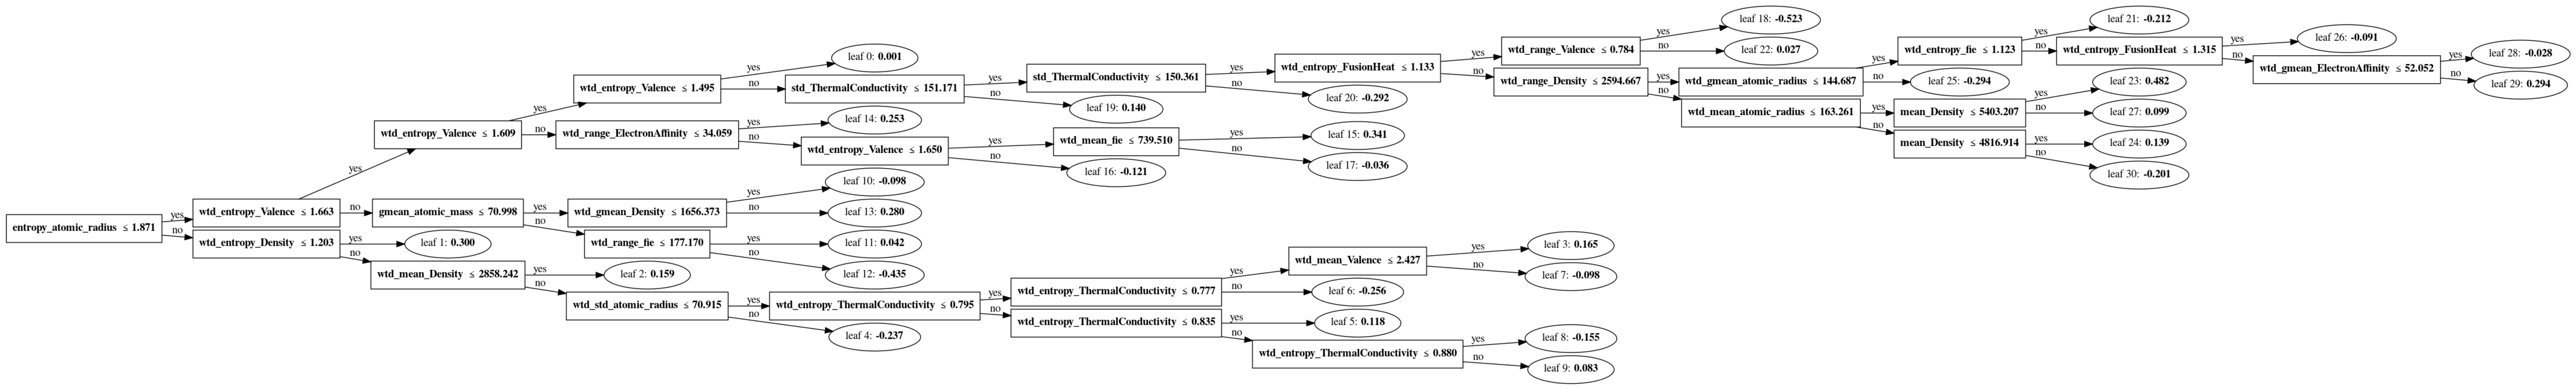

depth: 12

splits: [(25, 1.8714659443353903), (76, 1.6627175777872603), (76, 1.6086881942186653), (76, 1.4951795702779502), (69, 151.17056301657854), (69, 150.36133915523004), (56, 1.1329700828712201), (78, 0.7839479153111161), (38, 2594.66666666667), (24, 144.68723157032053), (16, 1.1233135092875204), (56, 1.315098241389285), (44, 52.05180999186455), (22, 163.26071428571453), (31, 5403.2072125), (31, 4816.914400000001), (48, 34.05906219512196), (76, 1.6502707129281602), (12, 739.5100000000001), (3, 70.99835177995526), (34, 1656.3729607234202), (18, 177.169977362762), (36, 1.2030666370387701), (32, 2858.24188692137), (30, 70.91484385794622), (66, 0.7954077689191951), (66, 0.7773332690655487), (72, 2.4269094922737304), (66, 0.8353589222893136), (66, 0.8797951536689871)]


In [7]:
#Example: The working of retrieve_lgbm is confirmed here through visualizing a tree from the ensemble.
##########
tree_index=random.randint(0,len(dictionary_lgbm['tree_info'])-1)
print(f'Tree index {tree_index}')

fig,ax=plt.subplots(figsize=(100,200))
lightgbm.plot_tree(model_lgbm,tree_index=tree_index,ax=ax)
plt.show()

temp=retrieve_lgbm(dictionary_lgbm['tree_info'][tree_index]['tree_structure'])
print(f'depth: {temp["depth"]}\n\nsplits: {temp["splits"]}')

How a XGBoost model is provided to us? 
--------------------------------------
Saving a XGBoost model (called model_xgb) as a .model file:

                        model_xgb.save_model('Regressor_XGB.model')
                        
Loading a saved XGBoost model:

                        model_xgb=xgboost.Booster()
                        model_xgb.load_model('Regressor_XGB.model')
                        
A XGBoost model can be dumped as a .txt or .json file, or as a data frame. <br>
https://stackoverflow.com/questions/50175901/how-to-extract-decision-rules-features-splits-from-xgboost-model-in-python3 <br />
https://stackoverflow.com/questions/37677496/how-to-get-access-of-individual-trees-of-a-xgboost-model-in-python-r

It is possible to extract trees from a .txt file.

                        model_xgb.get_booster().dump_model('Regressor_XGB.txt')
                        
But the .txt file typically does not include leaf weights. So we work with a dataframe instead. 

                        model_xgb.trees_to_dataframe()


In [8]:
#Importing a saved XGBoost model (a .model file) and dumping it as a data frame. 
XGB_model_name='Regressor_XGB_1'
extension='.model'
model_xgb=xgboost.Booster()
model_xgb.load_model('./Experiment_1/'+XGB_model_name+extension)
df=model_xgb.trees_to_dataframe()
df

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,f67,399.884216,0-1,0-2,0-1,8.021134e+06,12757.0,NaN
1,0,1,0-1,f31,5725.958010,0-3,0-4,0-3,1.308244e+05,6335.0,NaN
2,0,2,0-2,f64,0.836654,0-5,0-6,0-5,1.838466e+06,6422.0,NaN
3,0,3,0-3,f35,1.082034,0-7,0-8,0-7,6.408169e+04,2363.0,NaN
4,0,4,0-4,f65,1.231832,0-9,0-10,0-9,1.990198e+04,3972.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
25023,299,76,299-76,Leaf,NaN,NaN,NaN,NaN,-6.908115e-02,14.0,NaN
25024,299,77,299-77,Leaf,NaN,NaN,NaN,NaN,-1.249425e-01,1.0,NaN
25025,299,78,299-78,Leaf,NaN,NaN,NaN,NaN,-1.005692e+00,3.0,NaN
25026,299,79,299-79,Leaf,NaN,NaN,NaN,NaN,5.468473e-01,1.0,NaN


The Structure of data frames describing XGBoost models 
-----------------------------------------------------
The column 'Tree' can be used to recover any tree from the ensemble. 

In the subframe corresponding to a tree:
- each line corresponds to a node, either internal (corresponding to a split) or a leaf; 
- the column 'Feature' can be used to distinguish between a leaf and a non-terminal node; in the latter case, the fature on which the tree splits is recorded as a string 'fi' where $i$ is the feature index; 
- for a split, the corresponding threshold can be found in the 'Split' column; 
- columns 'Gain' and 'Cover' record the value and the number of training instances at a node;
- to find a node's parent, one need to find its 'ID' in the 'Yes' or 'No' column of another row (the row corresponding to its parent) where 'Yes' means feature value<threshold and 'No' captures the other alternative.          

In [9]:
#Data frames describing various trees in the ensemble can be obtained from segmenting the original one. 
tree_df=df[df['Tree']==1].reset_index(drop=True)    #We reset the index after segmentation.
print('The data frame describing tree of index 1:')
tree_df

The data frame describing tree of index 1:


,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,1,0,1-0,f67,399.884216,1-1,1-2,1-1,3.939443e+06,12757.0,NaN
1,1,1,1-1,f31,5725.958010,1-3,1-4,1-3,6.484169e+04,6335.0,NaN
2,1,2,1-2,f64,0.753388,1-5,1-6,1-5,8.998410e+05,6422.0,NaN
3,1,3,1-3,f35,1.082034,1-7,1-8,1-7,3.153527e+04,2363.0,NaN
4,1,4,1-4,f65,1.215214,1-9,1-10,1-9,1.023001e+04,3972.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
112,1,112,1-112,Leaf,NaN,NaN,NaN,NaN,1.742870e+01,306.0,NaN
113,1,113,1-113,Leaf,NaN,NaN,NaN,NaN,1.583911e+01,817.0,NaN
114,1,114,1-114,Leaf,NaN,NaN,NaN,NaN,2.263837e+01,155.0,NaN
115,1,115,1-115,Leaf,NaN,NaN,NaN,NaN,1.609499e+00,32.0,NaN


The function retrieve_xgb
-------------------------
A data frame tree_df describing a tree of a XGBoost model is passed to the function 

                 retrieve_xgb(tree_df)
which retrieves the structural information of the tree and returns it as a dictionary called info with keys

                 info.keys()=['depth', 'n_leaves', 'splits', 'distinct_feature_indx', 'regions']
as described before. 

In [10]:
def retrieve_xgb(tree_df):
    
    split_rows=tree_df.index[tree_df['Feature']!='Leaf'].to_list()         #rows corresponding to splits
    leaf_rows=tree_df.index[tree_df['Feature']=='Leaf'].to_list()          #rows corresponding to leaves

    
    info={}
    info['n_leaves']=len(leaf_rows)
    info['splits']=[]
    info['distinct_feature_indx']=[]
    
    for i in split_rows:                                           #Recording splits and distinct features                                        
        feature_index=int(tree_df['Feature'][i][1:])
        threshold=tree_df['Split'][i]   
        info['splits']+=[(feature_index,threshold)]
        if feature_index not in info['distinct_feature_indx']:
            info['distinct_feature_indx']+=[feature_index]
            
            
    info['regions']=[]                                             #The region corresponding to a leaf is recovered through calling an auxiliary function.
    depth=0     
    total_weight=0                                                 #This will be used to obtain probabilities of regions. 
    for i in leaf_rows:  
        region=retrieve_xgb_region(tree_df,i)
        depth=max(depth,region['depth'])                           #We compare depths of all regions to obtain tree's depth.
        total_weight+=region['weight']
        del region['depth']                                        #Deleting the auxiliary key for depth
        info['regions']+=[region]
        
    for region in info['regions']:
        region['probability']=region['weight']/total_weight
    
    info['depth']=depth
    return info

######################################################## Auxiliary Functions #####################################
#Retruns the region corresponding to the leaf appearing on a given row of the data frame. 
def retrieve_xgb_region(tree_df,leaf_row):                        
    region={}
    region['value']=tree_df['Gain'][leaf_row]
    region['weight']=tree_df['Cover'][leaf_row]
    
    row_index=leaf_row
    depth=0
    while True:                                                       #Going up from the leaf until we reach the root. 
        if row_index==0:                                              #In this case, we have reached the root, there is nothing more to do. 
            break
        depth+=1
        if len(tree_df.index[tree_df['Yes']==tree_df['ID'][row_index]].to_list())>0: 
            kind='upper'                                              #feature value<threshold on the Yes column
            row_index=tree_df.index[tree_df['Yes']==tree_df['ID'][row_index]].to_list()[0]
        else:                                                         #feature value>threshold on the No column
            kind='lower'
            row_index=tree_df.index[tree_df['No']==tree_df['ID'][row_index]].to_list()[0]
        feature_index=int(tree_df['Feature'][row_index][1:])          #feature_index and threshold for the parent (to be considered in the next iteration)
        threshold=tree_df['Split'][row_index]
        if feature_index in region.keys():                            #If the feature already appears, we modify the interval; otherwise, we add it as a new key. 
            region[feature_index]=modify_interval(region[feature_index],threshold,kind)
        else:
            if kind=='upper':
                region[feature_index]=[-float('inf'),threshold]
            else:
                region[feature_index]=[threshold,float('inf')]
    
    region['depth']=depth                              
    return region


#This function appeared before. 
def modify_interval(interval,bound,kind):
    if interval==None:                      #Nothing to modify if the interval is empty to begin with. 
        return None
    if kind=='upper':
        if interval[0]>=bound:
            return None
        else:
            interval[1]=min(interval[1],bound)
    else:
        if interval[1]<=bound:
            return None
        else:
            interval[0]=max(interval[0],bound)
    return interval            
        

The two cells below provide sanity checks for retireve_xgb.

In [11]:
#Example: XGBoost has a built in method for computing the leaf index. 
#This is the index appearing in the data frame for 'ID' column. So the number of non-terminal leaves coming before it should be subtracted.
#For a sample point from an arbitrarily chosen region obtained from retrieve_xgb, the leaf index obtained from XGBoost must match region's index.
##########
tree_index=random.randint(0,len(df['Tree'].unique().tolist())-1)
tree_df=df[df['Tree']==tree_index].reset_index(drop=True)
info=retrieve_xgb(tree_df)
depth=info['depth']
n_regions=info['n_leaves']
region_index=random.randint(0,n_regions-1)
region=info['regions'][region_index]
print(f'We are looking at region index {region_index} of tree index {tree_index} of the ensemble:')
print(region)
        

#Picking a data point from that region: 
data_instance=np.zeros([1,81])                                #(81 is the number of variables of models in Experiment_1)
for key in region:
    if key in {'value','weight','probability'}:
        continue
    if region[key][0]==-float('inf'):
        data_instance[0][key]=region[key][1]-1
    elif region[key][1]==float('inf'):
        data_instance[0][key]=region[key][0]+1
    else:
        data_instance[0][key]=0.5*(region[key][0]+region[key][1])

#Leaf index from XGBoost's built-in method, this is the row index in the data frame
real_index=int(model_xgb.predict(xgboost.DMatrix(data_instance),pred_leaf=True)[0][tree_index])
#Number of non-terminal rows before should be subtracted
difference=tree_df.iloc[:real_index][tree_df.iloc[:real_index]['Feature']!='Leaf'].shape[0]

print('\nThe region index based on a built-in method of XGBoost is:',
          real_index-difference)        

We are looking at region index 26 of tree index 178 of the ensemble:
{'value': -0.0148352319, 'weight': 8.0, 42: [-inf, 30.8959999], 48: [-inf, 44.287323], 55: [-inf, 0.920909166], 9: [34.3148613, inf], 69: [23.4516525, 26.6025219], 'probability': 0.000627106686525045}

The region index based on a built-in method of XGBoost is: 26


Tree index 159


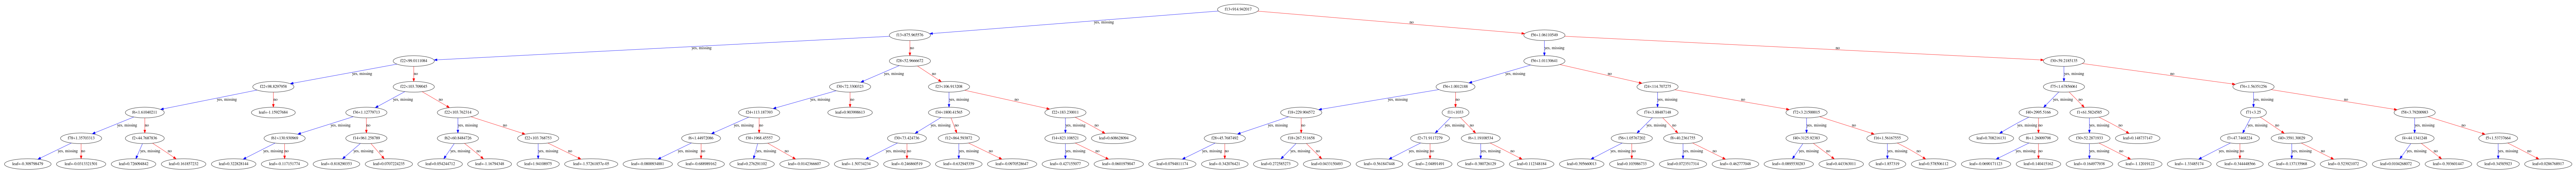

depth: 6

splits: [(13, 914.942017), (13, 875.965576), (56, 1.06110549), (22, 99.0111084), (28, 52.9666672), (56, 1.01130641), (30, 59.2185135), (22, 98.8297958), (22, 103.709045), (30, 72.3300323), (23, 106.913208), (56, 1.0012188), (24, 114.707275), (75, 1.67856061), (76, 1.56351256), (6, 1.61040211), (36, 1.12779713), (22, 103.762314), (24, 113.187393), (34, 1800.41565), (22, 183.230011), (18, 229.904572), (11, 1033.0), (74, 3.88487148), (72, 3.21500015), (40, 2995.5166), (1, 61.5824585), (71, 3.25), (58, 3.79200983), (78, 1.35703313), (2, 44.7687836), (61, 130.930969), (14, 961.258789), (62, 60.8484726), (22, 103.768753), (6, 1.44972086), (38, 1968.45557), (30, 73.424736), (12, 864.593872), (14, 823.108521), (28, 45.7687492), (18, 267.511658), (2, 71.9117279), (6, 1.19108534), (56, 1.05767202), (8, 40.2361755), (40, 3125.92383), (16, 1.56167555), (6, 1.26009798), (30, 52.2871933), (3, 47.7468224), (40, 3591.30029), (4, 44.1341248), (5, 1.53737664)]

The region corresponding to the 

In [12]:
#Example: The working of retrieve_xgb is confirmed here through visualizing a tree from the ensemble.
##########
tree_index=random.randint(0,len(df['Tree'].unique().tolist())-1)
leaf_index=random.randint(0,3)

print(f'Tree index {tree_index}')
fig, ax = plt.subplots(figsize=(100, 200))
plot_tree(model_xgb, num_trees=tree_index, ax=ax)                            
plt.show()

temp=retrieve_xgb(df[df['Tree']==tree_index].reset_index(drop=True))
print(f'depth: {temp["depth"]}\n\nsplits: {temp["splits"]}\n\nThe region corresponding to the leaf index {leaf_index}: {temp["regions"][leaf_index]}')
print('(Caution: Find the leaves in the plot through following the splits. They do not appear in the same order as in the output of retrieve_xgb.)')

How a CatBoost model is provided to us? 
---------------------------------------
Saving a CatBoost model (called model_cat) as a .model file:

                        model_cat.save_model('Regressor_CatBoost',format='json')
                        
(Also possible to save as a .model file.)

Given the .json file, one can dump the model as a dictionary: 

                        model_cat=open('Regressor_CatBoost')
                        dictionary_catboost=json.load(model_cat)
                
(Also possible to load the model as a CatBoost classifier or Regressor: https://stackoverflow.com/questions/51895761/how-to-correctly-load-pretrained-model-in-catboost-in-python)

In [13]:
#Importing a saved CatBoost model (a .model file) and dumping it as a dictionary. 
#(The code would be shorter if the model is provided as a .json file.)
#The CatBoost model here is a Regressor. 


CatBoost_model_name='Regressor_CatBoost_1'
extension='.model'
model_cat=CatBoostRegressor()
model_cat.load_model('./Experiment_1/'+CatBoost_model_name+extension)
model_cat.save_model('Regressor_CatBoost',format='json')
model=open('Regressor_CatBoost')
dictionary_catboost=json.load(model)
os.remove('Regressor_CatBoost')

print('The keys of the dictionary:',dictionary_catboost.keys())
print('\nThe size of the ensemble is:',len(dictionary_catboost['oblivious_trees']))
print('\nThe keys of the dictionary descrribing tree index 0:',dictionary_catboost['oblivious_trees'][0].keys())

The keys of the dictionary: dict_keys(['features_info', 'model_info', 'oblivious_trees', 'scale_and_bias'])

The size of the ensemble is: 300

The keys of the dictionary descrribing tree index 0: dict_keys(['leaf_values', 'leaf_weights', 'splits'])


The Structure of dictionaries describing CatBoost models 
--------------------------------------------------------
The dictionary obtained from dumping a CatBoost model, say dictionary_catboost, has various keys. 
Information about the trees is stored in 

                        dictionary_catboost['oblivious_trees']                       
This is a list with one entry for each tree which is a dictionary itself  

                        dictionary_catboost['oblivious_trees'][i].keys()
                        =['leaf_values', 'leaf_weights', 'splits']
Trees in a CatBoost model are oblivious. So we just need to record one splits per level. This is where 

                        dictionary_catboost['oblivious_trees'][i]['splits']
is used. From this list of all splits taking place in the tree (one per level), for each split the feature index and the threshold may be recovered. The list is bottom-up, the splits closer to the root appear at the end. 

(Detailed guides on extracting internal parameters of saved CatBoost models: 
http://parasmalik.blogspot.com/2020/
https://colab.research.google.com/github/catboost/tutorials/blob/master/model_analysis/model_export_as_json_tutorial.ipynb)

In [14]:
#Example (Notice that a feature may come up more than once which will definitely cause in empty regions.)
dictionary_catboost['oblivious_trees'][178]['splits']

[{'border': 1.0393215417861938,
  'float_feature_index': 16,
  'split_index': 368,
  'split_type': 'FloatFeature'},
 {'border': 1.0427782535552979,
  'float_feature_index': 16,
  'split_index': 369,
  'split_type': 'FloatFeature'},
 {'border': 946.6575927734375,
  'float_feature_index': 14,
  'split_index': 337,
  'split_type': 'FloatFeature'},
 {'border': 945.2777099609375,
  'float_feature_index': 14,
  'split_index': 335,
  'split_type': 'FloatFeature'},
 {'border': 13.180000305175781,
  'float_feature_index': 57,
  'split_index': 1321,
  'split_type': 'FloatFeature'},
 {'border': 1.2957968711853027,
  'float_feature_index': 54,
  'split_index': 1241,
  'split_type': 'FloatFeature'},
 {'border': 74.19512939453125,
  'float_feature_index': 34,
  'split_index': 808,
  'split_type': 'FloatFeature'},
 {'border': 76.81771850585938,
  'float_feature_index': 30,
  'split_index': 701,
  'split_type': 'FloatFeature'}]

The function retrieve_catboost
-------------------------------
A dictionary describing a tree of a CatBoost model, say dictionary_catboost['oblivious_trees'][0], is passed to the function 

                 retrieve_catboost(tree_structure)
which retrieves the structural information of the tree and returns it as a dictionary called info with keys

                 info.keys()=['depth', 'n_leaves', 'splits', 'distinct_feature_indx', 'regions']
as described before. 

In [15]:
#The input tree_structure is a dictionary with keys 'leaf_values', 'leaf_weights' and 'splits'. 
#The codes is considerably easier since the tree is oblivious. 

def retrieve_catboost(tree_structure):
    #Initializing the dictionary:
    info={}
    
    #The first two keys are easy:
    info['depth']=len(tree_structure['splits'])
    info['n_leaves']=2**info['depth']
    
    #Initializing the next two keys:
    info['splits']=[]
    info['distinct_feature_indx']=[]
    
    for split in tree_structure['splits']:               #Each element of tree_structure['splits'] describes a splitting that takes place across an entire level.
        if split['float_feature_index'] not in info['distinct_feature_indx']:
            info['distinct_feature_indx']+=[split['float_feature_index']]
        info['splits']+=[(split['float_feature_index'],split['border'])]
        
    
    #It remains to compute info['region'], a list comprised of one dictionary per region. 
    #Initializing:
    info['regions']=[]
    
    for i in range(2**info['depth']):
        #Constructing the dictionary describing this region:
        region={}
        region['value']=tree_structure['leaf_values'][i]
        region['weight']=tree_structure['leaf_weights'][i]
        
        #Initializing the keys that describe bounds for each feature.
        for feature_index in info['distinct_feature_indx']:
            region[feature_index]=[-float('inf'),float('inf')]
            
        expansion='{0:b}'.format(i)                          #The binary expansion of i which is the index of the leaf/region under consideration.
        while len(expansion)<info['depth']:                  #(An integer from [0,2**depth-1], we want len(expansion)=depth.) 
            expansion='0'+expansion
                                                             
        for j in range(info['depth']):                       #The leftmost characters of the expansion are determined by top splits near 
            feature_index=info['splits'][-j-1][0]            #the root which are encoded by the rightmost entries of info['splits'].         
            threshold=info['splits'][-j-1][1]                #(Keep in mind that splits closer to the root appear at the end of tree_structure['splits']).
            
            if expansion[j]=='0':                            #Meaning we go to the left since feature_value<threshold.
                region[feature_index]=modify_interval(region[feature_index],threshold,'upper')
            else:                                            #Meaning we go to the left since feature_value>threshold.
                region[feature_index]=modify_interval(region[feature_index],threshold,'lower')
        
        #Adding the dictionary constructed for this region to info['regions'].
        info['regions']+=[region]
        
        
    #Adding a key for porbability to each dictionary from info['regions']
    total_weight=0
    for region in info['regions']:
        total_weight+=region['weight']
    for region in info['regions']:
        region['probability']=region['weight']/total_weight
    
    return info

############

#This function appeared before. 
def modify_interval(interval,bound,kind):
    if interval==None:                      #Nothing to modify if the interval is empty to begin with. 
        return None
    if kind=='upper':
        if interval[0]>=bound:
            return None
        else:
            interval[1]=min(interval[1],bound)
    else:
        if interval[1]<=bound:
            return None
        else:
            interval[0]=max(interval[0],bound)
    return interval            

The two cells below provide sanity checks for retireve_catboost.

In [16]:
#Example: CatBoost has a built in method for computing the leaf index. 
#For a sample point from an arbitrarily chosen region obtained from retrieve_catboost, the leaf index obtained from CatBoost must match region's index.
##########
tree_index=random.randint(0,len(dictionary_catboost['oblivious_trees'])-1)
info=retrieve_catboost(dictionary_catboost['oblivious_trees'][tree_index])
depth=info['depth']
region_index=random.randint(0,2**depth-1)
region=info['regions'][region_index]
print(f'We are looking at region index {region_index} of tree index {tree_index} of the ensemble:')
print(region)

#(Since the tree is oblivious, there are definitely vacuous regions if a feature appears more than once.)
not_vacuous=True                                                  
for key in region.keys():
    if region[key]==None:
        not_vacuous=False
        print('\nThis region is empty, run the code again.')
        break
        
        
if not_vacuous:
    #Picking a data point from that region: 
    data_instance=np.zeros([1,81])                                #(81 is the number of variables of models in Experiment_1)
    for key in region:
        if key in {'value','weight','probability'}:
            continue
        if region[key][0]==-float('inf'):
            data_instance[0][key]=region[key][1]-1
        elif region[key][1]==float('inf'):
            data_instance[0][key]=region[key][0]+1
        else:
            data_instance[0][key]=0.5*(region[key][0]+region[key][1])
    print('\nThe region index based on a built-in method of CatBoost is:',
          model_cat.calc_leaf_indexes(data_instance)[0][tree_index])



We are looking at region index 183 of tree index 285 of the ensemble:
{'value': -0.7747392086844739, 'weight': 1, 8: [7.566570281982422, inf], 30: [78.25398254394531, inf], 70: [184.90179443359375, inf], 45: [-inf, 1.4254817962646484], 64: [1.1339707374572754, inf], 12: [-inf, 995.6019287109375], 24: [90.18970489501953, inf], 'probability': 7.838833581563063e-05}

The region index based on a built-in method of CatBoost is: 183


Tree index 195


depth: 8

splits: [(67, 35.77549743652344), (19, 124.09660339355469), (28, 6.950488090515137), (74, 4.038230895996094), (50, 32.06188201904297), (11, 720.0032958984375), (44, 25.98908042907715), (52, 17.97706413269043)]
the region corresponding to leaf index 3: {'value': 0, 'weight': 0, 67: [35.77549743652344, inf], 19: [124.09660339355469, inf], 28: [-inf, 6.950488090515137], 74: [-inf, 4.038230895996094], 50: [-inf, 32.06188201904297], 11: [-inf, 720.0032958984375], 44: [-inf, 25.98908042907715], 52: [-inf, 17.97706413269043], 'probability': 0.0}


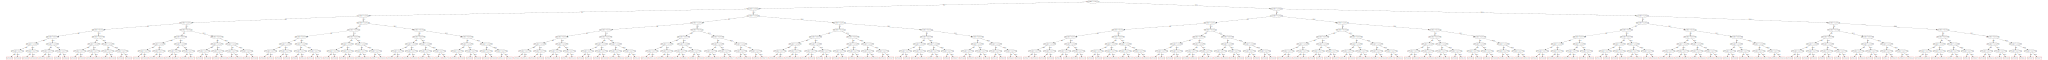

In [17]:
#Example: The working of retrieve_catboost is confirmed here through visualizing a tree from the ensemble.
##########
tree_index=random.randint(0,len(dictionary_catboost['oblivious_trees'])-1)
leaf_index=random.randint(0,4)
print(f'Tree index {tree_index}')
temp=retrieve_catboost(dictionary_catboost['oblivious_trees'][tree_index])
print(f'\n\ndepth: {temp["depth"]}\n\nsplits: {temp["splits"]}\nthe region corresponding to leaf index {leaf_index}: {temp["regions"][leaf_index]}')
model_cat.plot_tree(tree_idx=tree_index)

The cell below generates histograms and various statistics of the three ensembles for each of the four experiments. Only experiment_number should be declared (a number between 1 and 4).

Experiment number: 3 



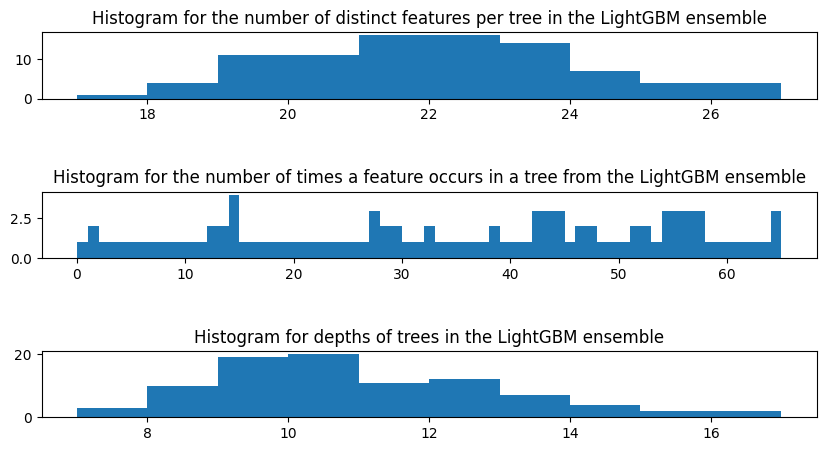

Size of the LightGBM ensemble: 88
Number of leaves across the LightGBM ensemble: [31]
The average number of distinct features per tree in the LightGBM ensemble: 21.6
The average number of times a feature comes up in a tree from the LightGBM ensemble: 32.78
The average depth of a tree from the LightGBM ensemble: 10.41




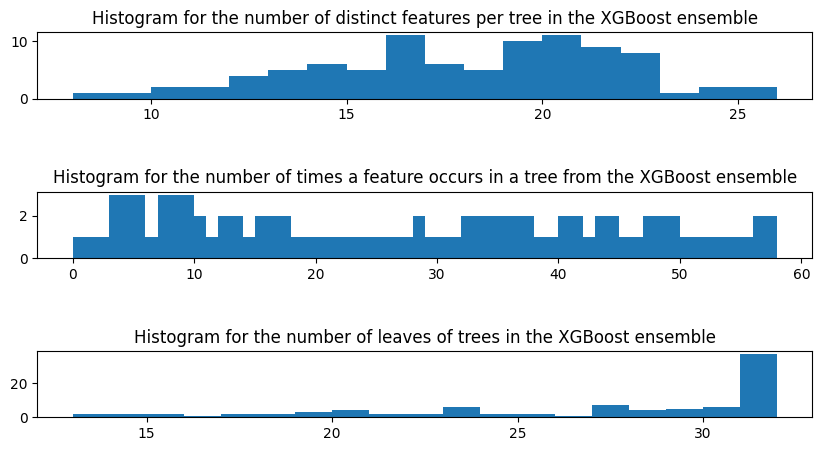

Size of the XGBoost ensemble: 88
The average number of leaves of a tree from the XGBoost ensemble: 27.09
The average number of distinct features per tree in the XGBoost ensemble: 17.78
The average number of times a feature comes up in a tree from the XGBoost ensemble: 26.98
Depths of trees across the XGBoost ensemble: [5]
The average depth of a tree from the XGBoost ensemble: 5.0




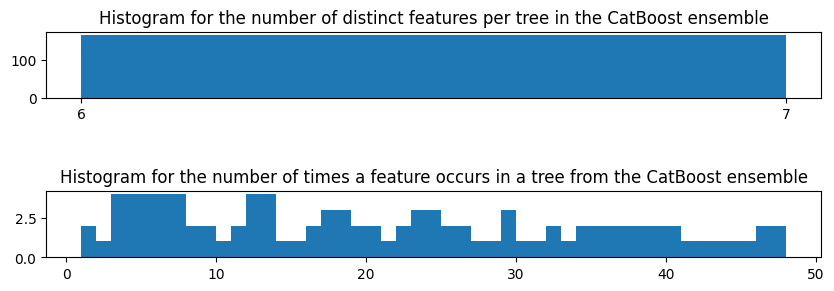

Size of the ensemble: 167
Number of leaves across the CatBoost ensemble: [128]
The average number of leaves of a tree from the CatBoost ensemble: 128.0
The average number of distinct features per tree in the CatBoost ensemble: 6.9
The average number of times a feature comes up in a tree from the CatBoost ensemble: 19.86
Depths of trees across the CatBoost ensemble: [7]
The average depth of a tree from the CatBoost ensemble: 7.0


In [18]:
#We generate histograms for the first triple of models. 
#For the other experiments, change experiment_number accordingly. 

experiment_number=3
if experiment_number not in {1,2,3,4}:
        raise ValueError('experiment_number should be 1,2,3 or 4.')
print(f'Experiment number: {experiment_number} \n')

#Determing the experiment's parameters:
if experiment_number==1:
    n_features=81
elif experiment_number==2:
    n_features=40
elif experiment_number==3:
    n_features=58
else:
    n_features=28
    
if experiment_number<=2:
    model_type='Regressor'
else:
    model_type='Classifier'
    

path='./Experiment_'+str(experiment_number)+'/'


######the LightGBM model######
model_lgbm=lightgbm.Booster(model_file=path+model_type+'_LightGBM_'+str(experiment_number)+'.model')
dictionary_lgbm=model_lgbm.dump_model()

tree_structures=[]
n_trees=len(dictionary_lgbm['tree_info'])
for i in range(0,n_trees):
            tree_structures+=[retrieve_lgbm(dictionary_lgbm['tree_info'][i]['tree_structure'])]

feature_occurrences=np.zeros(n_features)
for info in tree_structures:
    for i in info['distinct_feature_indx']:
        feature_occurrences[i]+=1
        
n_distinct_features=[]
n_leaves=[]
depths=[]
for info in tree_structures:
    n_distinct_features+=[len(info['distinct_feature_indx'])]
    n_leaves+=[info['n_leaves']]
    depths+=[info['depth']]
    

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,3)
ax3=fig.add_subplot(5,1,5)

ax1.hist(n_distinct_features,bins=np.unique(np.array(n_distinct_features)))
ax1.locator_params(axis='x', integer=True)
ax1.set_title('Histogram for the number of distinct features per tree in the LightGBM ensemble')
#plt.ylabel('Number of trees')

ax2.hist(feature_occurrences,bins=np.unique(np.array(feature_occurrences)))
ax2.locator_params(axis='x', integer=True)
#plt.xlabel('Number of trees of the LightGBM ensemble in which a feature appears')
ax2.set_title('Histogram for the number of times a feature occurs in a tree from the LightGBM ensemble')

ax3.hist(depths,bins=np.unique(np.array(depths)))
ax3.locator_params(axis='x',integer=True)
ax3.set_title('Histogram for depths of trees in the LightGBM ensemble')

plt.show()

#Having integers on the horizontal axis of the histogram: 
#https://stackoverflow.com/questions/54771089/how-do-i-set-histogram-axis-to-always-be-an-integer

print('Size of the LightGBM ensemble:',n_trees)

print('Number of leaves across the LightGBM ensemble:',
      np.unique(np.array(n_leaves)))

print('The average number of distinct features per tree in the LightGBM ensemble:',
      round(np.array(n_distinct_features).sum()/len(n_distinct_features),2))

print('The average number of times a feature comes up in a tree from the LightGBM ensemble:',
      round(feature_occurrences.mean(),2))

print('The average depth of a tree from the LightGBM ensemble:',
     round(np.mean(np.array(depths)),2))

print('\n')

######the XGBoost model######
model_xgb=xgboost.Booster()
model_xgb.load_model(path+model_type+'_XGB_'+str(experiment_number)+'.model')
df=model_xgb.trees_to_dataframe()

tree_structures=[]
n_trees=len(df['Tree'].unique().tolist())
for i in range(0,n_trees):
            tree_structures+=[retrieve_xgb(df[df['Tree']==i].reset_index(drop=True))]
        
feature_occurrences=np.zeros(n_features)
for info in tree_structures:
    for i in info['distinct_feature_indx']:
        feature_occurrences[i]+=1

n_distinct_features=[]
n_leaves=[]
depths=[]
for info in tree_structures:
    n_distinct_features+=[len(info['distinct_feature_indx'])]
    n_leaves+=[info['n_leaves']]
    depths+=[info['depth']]
    

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,3)
ax3=fig.add_subplot(5,1,5)

ax1.hist(n_distinct_features,bins=np.unique(np.array(n_distinct_features)))
ax1.locator_params(axis='x', integer=True)
ax1.set_title('Histogram for the number of distinct features per tree in the XGBoost ensemble')
#plt.ylabel('Number of trees')

ax2.hist(feature_occurrences,bins=np.unique(feature_occurrences))
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of times a feature occurs in a tree from the XGBoost ensemble')

ax3.hist(n_leaves,bins=np.unique(np.array(n_leaves)))
ax3.locator_params(axis='x',integer=True)
ax3.set_title('Histogram for the number of leaves of trees in the XGBoost ensemble')

plt.show()


print('Size of the XGBoost ensemble:',n_trees)

print('The average number of leaves of a tree from the XGBoost ensemble:',
      round(np.array(n_leaves).mean(),2))
      

print('The average number of distinct features per tree in the XGBoost ensemble:',
      round(np.array(n_distinct_features).sum()/len(n_distinct_features),2))
     

print('The average number of times a feature comes up in a tree from the XGBoost ensemble:',
      round(feature_occurrences.mean(),2))
     
print('Depths of trees across the XGBoost ensemble:',
     np.unique(np.array(depths)))

print('The average depth of a tree from the XGBoost ensemble:',
     round(np.mean(np.array(depths)),2))

print('\n')

######the CatBoost model######
if model_type=='Regressor':
    model_cat=CatBoostRegressor()
else:
    model_cat=CatBoostClassifier()
model_cat.load_model(path+model_type+'_CatBoost_'+str(experiment_number)+'.model')
model_cat.save_model('temp',format='json')
model=open('temp')
dictionary_catboost=json.load(model)
os.remove('temp')


tree_structures=[]
n_trees=len(dictionary_catboost['oblivious_trees'])
for i in range(0,n_trees):
            tree_structures+=[retrieve_catboost(dictionary_catboost['oblivious_trees'][i])]

feature_occurrences=np.zeros(n_features)
for info in tree_structures:
    for i in info['distinct_feature_indx']:
        feature_occurrences[i]+=1

n_distinct_features=[]
n_leaves=[]
depths=[]
for info in tree_structures:
    n_distinct_features+=[len(info['distinct_feature_indx'])]
    n_leaves+=[info['n_leaves']]
    depths+=[info['depth']]
    

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,3)


ax1.hist(n_distinct_features,bins=np.unique(np.array(n_distinct_features)))
ax1.locator_params(axis='x', integer=True)
ax1.set_title('Histogram for the number of distinct features per tree in the CatBoost ensemble')
#plt.ylabel('Number of trees')

ax2.hist(feature_occurrences,bins=np.unique(np.array(feature_occurrences)))
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of times a feature occurs in a tree from the CatBoost ensemble')


plt.show()



print('Size of the ensemble:',n_trees)

print('Number of leaves across the CatBoost ensemble:',
      np.unique(np.array(n_leaves)))

print('The average number of leaves of a tree from the CatBoost ensemble:',
      round(np.array(n_leaves).mean(),2))

print('The average number of distinct features per tree in the CatBoost ensemble:',
      round(np.array(n_distinct_features).sum()/len(n_distinct_features),2))

print('The average number of times a feature comes up in a tree from the CatBoost ensemble:',
      round(feature_occurrences.mean(),2))
 
print('Depths of trees across the CatBoost ensemble:',
     np.unique(np.array(depths)))

print('The average depth of a tree from the CatBoost ensemble:',
     round(np.mean(np.array(depths)),2))
